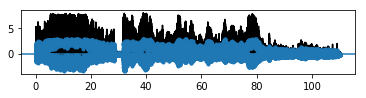

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from neo.io import AxonIO
 
# import the data
flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephy_data_07_03/'


localfile = flydir + '2018_03_05_0024.abf'
 
r = AxonIO(localfile)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]


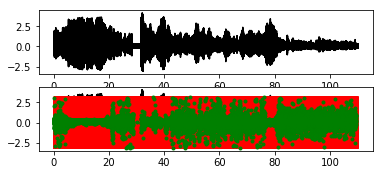

In [153]:
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')


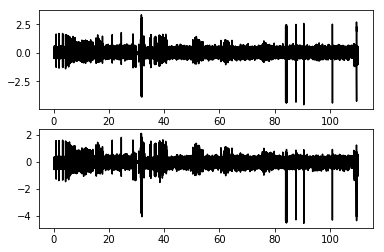

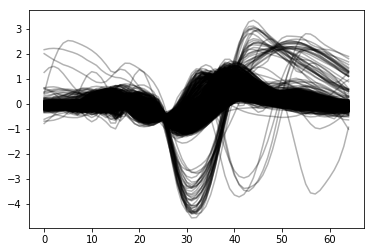

In [154]:
#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh = 0.6 #was 0.6
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])


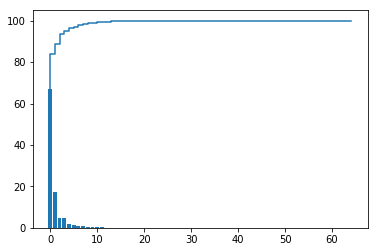

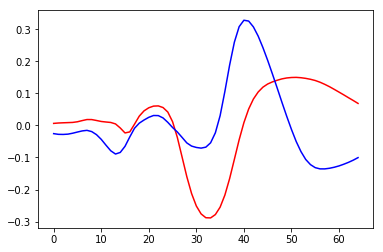

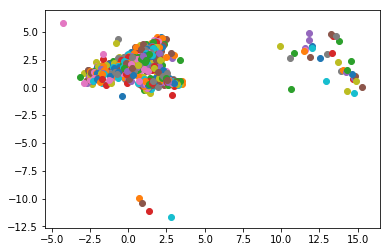

In [155]:

#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))


[[13.08498109  2.3577639 ]
 [ 0.69487465  1.93060681]]


' \ntest3 = np.argwhere(labels=0)\n\nfor i in range(len(test3)):\n   plt.plot(wv_mtrx[test3[i]])\n'

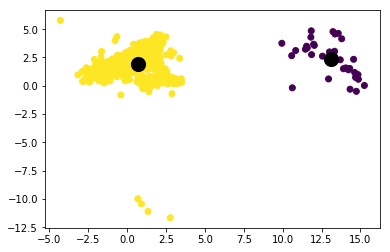

In [157]:
 
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
n_clusters=2
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""
    

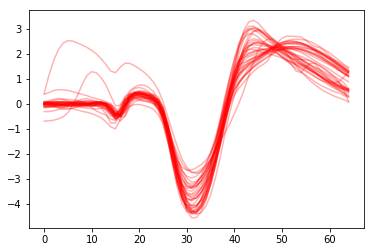

In [158]:
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)


def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_a_spikes = cutoff(0.5, labeled_spikes)

def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)



#print(zip_hutch)
#
#x_val = [x[0] for x in Type_a_spikes]
#y_val = [x[1] for x in Type_a_spikes]

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]


#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
#plt.figure(3)
#for i in range(len(labeled_waveforms_type_a)):
#    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)


In [159]:
counter = 0

avg_window = 30.
avg_window_list = list(range(-avg_window/2, avg_window))

spike_frequency= []

for avg_window in range(len(musc_det)):
    for w, window in avg_window_list:
        for s, spike in x_val_b:
            if musc_det[t+i] == musc_det[s]:
                counter += 1
    spike_frequency.append(counter)
    counter = 0

TypeError: range() integer end argument expected, got float.

In [160]:

avg_window_list = range(30)
avg_window_array = np.array(avg_window_list)#- (avg_window/2) 
#a[:] = [x - 13 for x in a]

avg_window_array -= avg_window/2
#print(avg_window_array)
print(avg_window/2)

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

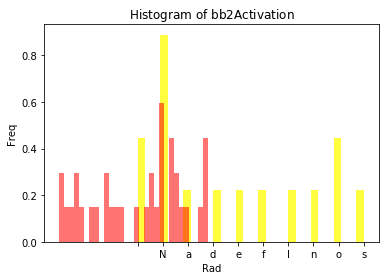

In [162]:

#%%
#With crimson light!

crimson = np.asarray(bl.segments[0].analogsignals[7])


plt.figure(13)
ax1 = plt.subplot(111)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

#split via crimson

#ax1.plot(times,crimson,'r')
#plt.fill_between(times[inds],crimson[inds])

#crimson_labeled_spikes_0= zip(inst_phase[x_val], crimson[x_val], musc[x_val])
crimson_labeled_spikes_2= zip(inst_phase[x_val_b], crimson[x_val_b], musc[x_val_b])


def cutoff_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] > threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_crimson = cutoff_crimson(.2, crimson_labeled_spikes_2)

def cutoff_no_crimson(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList2 = filter(lambda x: x[1] < threshold, sortedData)
    finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_0)
Spikes_2_no_crimson = cutoff_no_crimson(0.2, crimson_labeled_spikes_2)



#print(zip_hutch)


#x_val_crimson_1 = [x[0] for x in Spikes_1_crimson]
x_val_crimson_2 = [x[0] for x in Spikes_2_crimson] #COMPARING PHASE


#x_val_no_crim_1 = [x[0] for x in Spikes_1_no_crimson]

x_val_no_crim_2 = [x[0] for x in Spikes_2_no_crimson]


#labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

#labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]


#hist_crimson_spikes = x_val_crimson_1 
#hist_no_crimson_spikes = x_val_no_crim_1 

hist_crimson_spikes = x_val_crimson_2
hist_no_crimson_spikes = x_val_no_crim_2

matplotlib.pyplot.hist(hist_crimson_spikes, bins=30, normed=1, facecolor='yellow', alpha=0.75)
matplotlib.pyplot.hist(hist_no_crimson_spikes, bins=30, normed=1, facecolor='red', alpha=0.55)


#mu, sigma = 100, 15
bins = 40
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
#n, bins, patches = plt.hist(musc_det[x_val_0], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Rad')
plt.ylabel('Freq')
plt.title(r'$\mathrm{Histogram\ of\ bb2  Activation}$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(False)

plt.show()

# sanity check: just plot instantaneous phase over the whole experiment
#plt.figure(14)
#plt.plot(inst_phase[x_val_b], 'k')

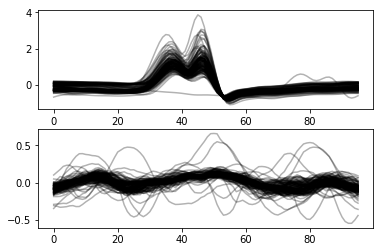

In [163]:

#%% gather a subset of the hütchens before and during a stimulus period to display them overlaid
hutch_seg = hutch[928548:948438]
musc_seg = musc[928548:948438]

deltas = np.diff(np.array(-1*hutch_det[928548:948438]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.subplot(211)
for i in range(len(hut_waveforms)):
    plt.plot(hut_waveforms[i], 'k', alpha = 0.3)
    
plt.subplot(212)
for i in range(len(musc_wave)):
    plt.plot(musc_wave[i], 'k', alpha = 0.3)


 
#%% save the data (change the trial directory each time)

import pandas as pd

hist_crimson_spikes = pd.DataFrame((hist_crimson_spikes))
hist_crimson_spikes.to_csv(flydir + 'S157_1/hist_crimson_spikes_b2.csv', index=False)

hist_no_crimson_spikes = pd.DataFrame((hist_no_crimson_spikes))
hist_no_crimson_spikes.to_csv(flydir + 'S157_1/hist_no_crimson_spikes_b2.csv', index=False)



In [164]:
###Find crimson onset times ###

idxs= list(range(len(times)))
idxs=np.asarray(idxs)

#crimson_times = zip(times, crimson)
crimson_idxs = zip(idxs, crimson)

stimulus_diff = np.diff(crimson)
crimson_diff_times = zip (idxs, stimulus_diff)

def det_crim_onset(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    #finalList =filter(lambda x: x[0] < 45, finalList2)
    return finalList if len(finalList) > 2 else 'No values found'

#Spikes_1_crimson = cutoff_crimson(0.2, crimson_labeled_spikes_0)
crimson_onset_points = det_crim_onset(.5, crimson_diff_times)

#crimson_onset_times = [x[0] for x in crimson_onset_points]
crimson_onset_indx= [x[0] for x in crimson_onset_points]

In [165]:
freq = np.asarray(bl.segments[0].analogsignals[4])



In [166]:
####WSA (L-R)

L = np.asarray(bl.segments[0].analogsignals[1])
R = np.asarray(bl.segments[0].analogsignals[2])
WSA = L - R

L_times = zip(times, L)
R_times = zip(times, R)
WSA_times = zip(times, WSA)

for i in range(len(crimson_onset_indx)):
    k= str(i)
    L_clip= pd.DataFrame(L[crimson_onset_indx[i]-20000:crimson_onset_indx[i]+40000])
    L_clip.to_csv(flydir + '/S157_1/' + k + 'b2_L_analysis.csv', index=False)
    
for i in range(len(crimson_onset_indx)):
    k= str(i)
    R_clip= pd.DataFrame(R[crimson_onset_indx[i]-20000:crimson_onset_indx[i]+40000])
    R_clip.to_csv(flydir + '/S157_1/' + k + 'b2_R_analysis.csv', index=False)

for i in range(len(crimson_onset_indx)):
    k= str(i)
    WSA_clip= pd.DataFrame(WSA[crimson_onset_indx[i]-20000:crimson_onset_indx[i]+40000])
    WSA_clip.to_csv(flydir + '/S157_1/' + k + 'b2_WSA_analysis.csv', index=False)

In [167]:
####WBF

freq = np.asarray(bl.segments[0].analogsignals[4])

freq_times = zip(times, freq)

for i in range(len(crimson_onset_indx)):
    k= str(i)
    freq_clip= pd.DataFrame(freq[crimson_onset_indx[i]-20000:crimson_onset_indx[i]+40000])
    freq_clip.to_csv(flydir + '/S157_1/' + k + 'b2_freq_analysis.csv', index=False)


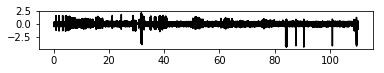

In [168]:
ax = plt.subplot(511)
ax.plot(times,musc_det,'k')

 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh = 0.6 #was 0.6
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  